In [1]:
# Load "news_sample.parquet" into a dataframe
import pandas as pd
df = pd.read_parquet("fakenewsproject/data/train.parquet", columns=["tokens", "type"])
df.head()

,tokens,type
__null_dask_index__,,
27,"headline,bitcoin,blockchain,searches,exceed,tr...",fake
28,"water,cooler,1,25,18,open,thread,fake,news,cnn...",fake
29,"veteran,commentator,calls,growing,ethnonationa...",fake
30,"lost,words,hidden,words,otters,banks,books,rea...",fake
32,"scientists,doomsday,clock,ahead,30,seconds,clo...",fake


In [2]:
# Remove all duplicates
df = df.drop_duplicates()

# Balance dataset so we have the same number of "reliable" and "fake" news

# Get the number of "reliable" and "fake" news
reliable_count = df[df["type"] == "reliable"].shape[0]
fake_count = df[df["type"] == "fake"].shape[0]

# Get the minimum of the tw

min_count = min(reliable_count, fake_count)
# Divide by 2 to get the number of news we need to remove
min_count = int(min_count / 2)

print("Reliable count: ", reliable_count)
print("Fake count: ", fake_count)

# Balance the dataset so we have the same number of "reliable" and "fake" news
df = df.groupby("type").head(min_count)

# Shuffle the dataset
df = df.sample(frac=1).reset_index(drop=True)

# Get the number of "reliable" and "fake" news
reliable_count = df[df["type"] == "reliable"].shape[0]
fake_count = df[df["type"] == "fake"].shape[0]

print("Reliable count: ", reliable_count)
print("Fake count: ", fake_count)

Reliable count:  1626724
Fake count:  694504
Reliable count:  347252
Fake count:  347252


In [3]:
# Calculate tf-idf vectors for the text column
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=2048, sublinear_tf=True)

# Generate test and train sets, test set is the last 5000 rows
X_train = df["tokens"].iloc[:-5000]
X_test = df["tokens"].iloc[-5000:]
y_train = df["type"].iloc[:-5000]
y_test = df["type"].iloc[-5000:]
del df

# Fit the tf-idf model on the tokens, which need commas removed
X_train = tfidf.fit_transform(X_train.str.replace(",", " "))

In [4]:
# Train truncated SVD model
from sklearn.decomposition import TruncatedSVD
pca = TruncatedSVD(n_components=256)
X_train = pca.fit_transform(X_train)
# Print explained variance of each component
print(pca.explained_variance_ratio_)

[0.00700087 0.0111759  0.00990185 0.00886182 0.00738717 0.00635153
 0.00545126 0.0049254  0.00469852 0.00448967 0.0041026  0.00386494
 0.00360394 0.00344727 0.00319469 0.00310061 0.00303581 0.00291166
 0.00280626 0.0027264  0.00265004 0.00253484 0.00246258 0.00241451
 0.00229998 0.0022773  0.0022247  0.00220849 0.00209613 0.00207826
 0.00199485 0.001978   0.0019176  0.00189622 0.00187902 0.00186198
 0.00178929 0.00176984 0.0017342  0.00170018 0.001682   0.0016512
 0.00163638 0.00161511 0.00158734 0.00157109 0.00154627 0.00154072
 0.00151506 0.00147841 0.00146144 0.00145493 0.00143839 0.00143118
 0.00141305 0.00140453 0.00138518 0.00136695 0.00134355 0.00132979
 0.00132127 0.00131295 0.00129971 0.00128332 0.00126409 0.00125339
 0.00124967 0.00123605 0.00123453 0.00121825 0.00121602 0.00120105
 0.0011996  0.0011922  0.00118832 0.00118096 0.00117843 0.00116672
 0.00115899 0.00114668 0.00114134 0.00113973 0.00113176 0.00112648
 0.00111849 0.00111462 0.00110756 0.00109973 0.00109286 0.00109

In [7]:
# Transform X_test with tf-idf and pca
X_test = pca.transform(tfidf.transform(X_test.str.replace(",", " ")))

In [13]:
# train logistic regression model
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)
model = lr

# 92% accuracy


In [9]:
# Train random forest model
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_jobs=-1)
rf.fit(X_train, y_train)
model = rf

# 91% accuracy

In [11]:
# Try to train a linear SVM model
from sklearn.svm import LinearSVC
svm = LinearSVC()
svm.fit(X_train, y_train)
model = svm

# 91% accuracy

In [16]:
# Train a naive bayes model
from sklearn.naive_bayes import CategoricalNB
nb = CategoricalNB()
nb.fit(X_train, y_train)
model = nb
# Accuracy of 49%, no predictive power

Score:  0.4946


Text(0, 0.5, 'True label')

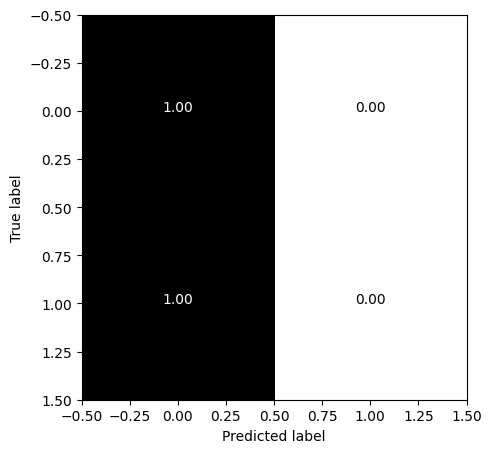

In [17]:
score = model.score(X_test, y_test)

print("Score: ", score)

# Calculate confusion matrix
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_test)

import matplotlib.pyplot as plt

# Make confusion matrix
confusion_matrix = confusion_matrix(y_test, y_pred, normalize="true")
# Plot confusion matrix
plt.figure(figsize=(5, 5))
plt.imshow(confusion_matrix, interpolation="nearest", cmap=plt.cm.gray_r)
for i in range(2):
    for j in range(2):
        plt.text(j, i, format(confusion_matrix[i, j], '.2f'), horizontalalignment="center", color="white" if confusion_matrix[i, j] > 0.5 else "black")
plt.xlabel("Predicted label")
plt.ylabel("True label")